In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st
import networkx # to install networkx in your environment: conda install networkx
from covid19model.models import models
from covid19model.models.compliance import logistic
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import polymod
from covid19model.data import parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
import math
import xarray as xr
import emcee
from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()
levels = initN.size

In [3]:
import json
with open('parameters.json', 'r') as fp:
    samples_dict = json.load(fp)

In [4]:
samples_dict.keys()

dict_keys(['lag_time', 'beta', 'k', 't0', 'prevention', 'dc', 'dICU', 'dICUrec'])

In [5]:
lag_time = samples_dict['lag_time']

In [6]:
params = parameters.get_COVID19_SEIRD_parameters()
params.update({'beta':0.035,
               'k':   1,
               't0':5,
               'Nc': Nc_total})
initial_states = {'S': initN, 'E': np.ones(levels)}
model = models.COVID19_SEIRD(initial_states, params, compliance=logistic)

In [7]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
data=[df_sciensano["H_out"].values[:55],df_sciensano["ICU_tot"].values[:55],df_sciensano["H_tot_cumsum"].values[:55]]
states = [["H_out"],["ICU"],["H_tot"]]


In [8]:
start_date = '15March2020'
end_date = '15Oct2020'
model_time = int((pd.to_datetime(end_date) -  pd.to_datetime(start_date) + pd.to_timedelta(str(lag_time)+'D'))/pd.to_timedelta('1D'))
chkp_2 = (pd.to_datetime('2020-09-01')-pd.to_datetime(start_date))/pd.to_timedelta('1D')

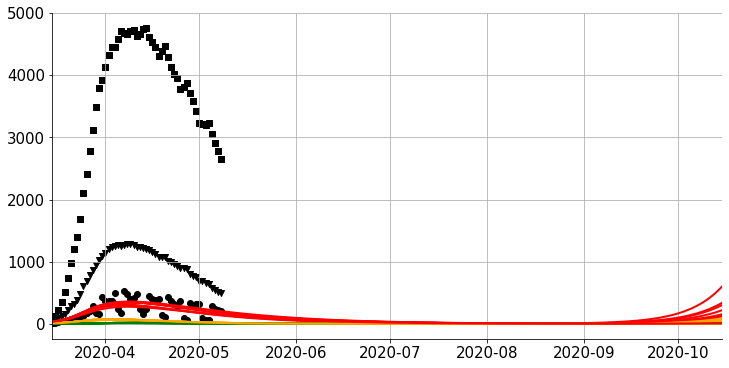

In [9]:
data_mkr=['o','v','s','*','^']
clr=['green','orange','red','black','blue']
plt_kwargs={'linewidth': 1,'alpha': 1}
sct_kwargs={}
    
fig,ax=plt.subplots(figsize=(12,6))
# Plot data
idx_data = pd.date_range(pd.to_datetime(start_date), end=pd.to_datetime(start_date)+datetime.timedelta(days=data[0].size-1),freq='D')
for i in range(len(data)):
    lines=ax.scatter(idx_data,data[i],color="black",marker=data_mkr[i],**sct_kwargs)

for i in range(10):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['k'] = np.random.choice(samples_dict['k'],1,replace=False)
    model.parameters['t0'] = np.random.choice(samples_dict['t0'],1,replace=False)
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    futurePolicy = {'time':     [lag_time,chkp_2],
                    'Nc':    [0.2*Nc_home + prevention*((1-0.70)*Nc_work + (1-0.80)*Nc_transport),
                              Nc_home+prevention*(Nc_work+Nc_transport)+Nc_schools],
                  }
    model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    model.parameters['dICUrec'] = np.random.choice(samples_dict['dICUrec'],1,replace=False)
    y_model = model.sim(model_time,checkpoints=futurePolicy)

    idx = pd.date_range(pd.to_datetime(start_date)-datetime.timedelta(days=lag_time), end=pd.to_datetime(end_date),freq='D')

    # Plot model prediction
    y_model_tot = y_model.sum(dim="stratification")
    for i in range(len(data)):
        data2plot = y_model_tot[states[i]].to_array(dim="states").values.ravel()
        lines = ax.plot(idx,data2plot,color=clr[i],**plt_kwargs)    

    ax.set_xlim(start_date, end_date)
    
    
#     ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
#                   legend_text=['Hospital discharges','Intensive care units (total)','Hospitals (total)'],
#                   plt_kwargs={'linewidth': 0.25,'alpha': 0.5}) # alpha:0.05